# 11.1 K-means 알고리즘을 사용하여 유사한 객체 그룹핑
## 11.1.1 사이킷런을 사용한 K-means 군집
구현하기 쉽고 다른 군집 알고리즘에 비해 계산 효율성이 높아 인기가 많음  
원형 클러스터를 구분하는 데 뛰어나지만, 사전에 클러스터 개수를 지정해야 함 -> 성능에 영향  
프로토타입 기반 군집: 각 클러스터가 하나의 프로토타입으로 표현됨
- 연속형 데이터: 비슷한 데이터 포인트의 센트로이드(평균)
- 범주형 데이터: 가장 대표되는 포인트나 가장 자주 등장하는 포인트 -> 메도이드

In [13]:
import warnings
warnings.filterwarnings(action='ignore')

In [14]:
plt.rc('font', family='Malgun Gothic') # 폰트 지정
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
%config InlineBackend.figure_format='retina' # 그래프 글씨 뚜렷

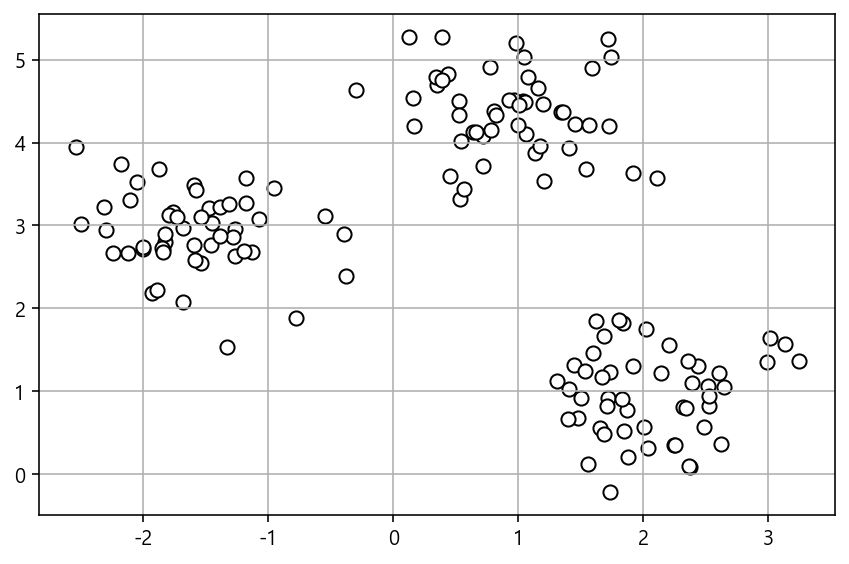

In [15]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=150, n_features=2, centers=3,
                 cluster_std=0.5, shuffle=True, random_state=0)

import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c='white',
           marker='o', edgecolors='black', s=50)

plt.grid()
plt.tight_layout()
plt.show()

In [16]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, # 클러스터 개수 지정
            init='random',
            n_init=10, # 알고리즘을 각기 다른 랜덤한 센트로이드에서 독립적으로 10번 실행
            max_iter=300, # 최대 반복횟수 지정
            tol=1e-04, # 수렴을 결정하는 클러스터 내 제곱 오차합의 변화량에 대한 허용 오차 조정 (=0.0001)
            random_state=0)
y_km = km.fit_predict(X)

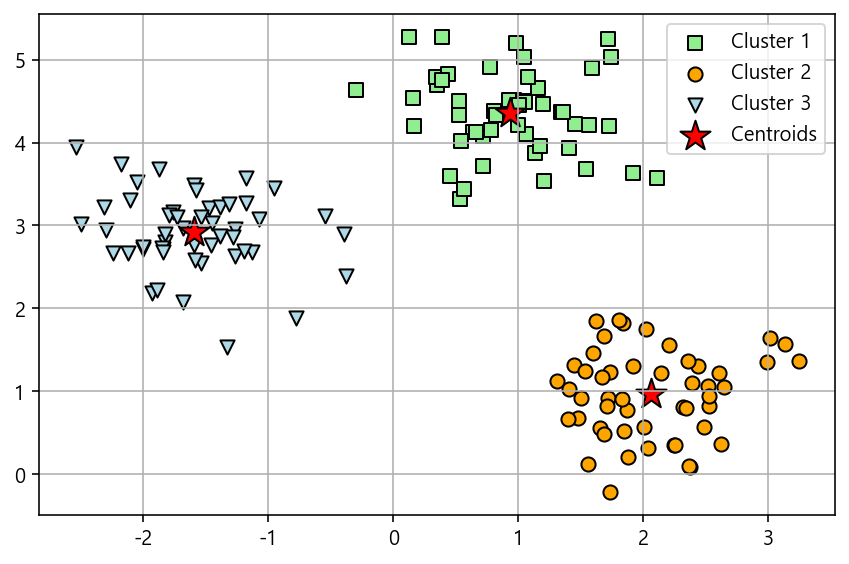

In [17]:
plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='Cluster 1')

plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='Cluster 2')

plt.scatter(X[y_km == 2, 0],
            X[y_km == 2, 1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='Cluster 3')

plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250, c='red',
            marker='*', edgecolor='black',
            label='Centroids')

plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
plt.show()

## 11.1.2 K-Means++ 로 초기 클러스터 센트로이드를 똑똑하게 할당
기본 k-평균 알고리즘은 센트로이드가 좋지 않게 선택되면 나쁜 군집 결과를 만들거나 수렴이 느려짐  
-> 같은 데이터셋에서 k-means 알고리즘을 여러번 실행하여 sse입장에서 가장 성능이 좋은 모델 선택하기  
-> 초기 센트로이드가 서로 멀리 떨어지게끔 위치시키는 것 (k-means ++)  

사이킷런에서 사용하려면 init='k-means++' 지정하기

## 11.1.3 직접군집 vs 간접군집
* 직접군집: 데이터셋의 샘플이 정확히 하나의 클러스터에 할당되는 알고리즘 종류 (ex. k-means, k-means++)
* 간접군집: 퍼지군집이라고도 함. 샘플을 하나 이상의 클러스터에 할당. (ex. 퍼지 C-평균)

## 11.1.4 엘보우 방법을 이용해 최적의 클러스터 개수 찾기
비지도 학습에서 가장 어려운 점: 최종 답 X -> 데이터셋에 진짜 클래스 레이블 X  
군집 품질을 평가하려면 알고리즘 자체의 지표를 사용해야 함 (SSE)  
엘보우 방법: 그래프를 통해 왜곡이 빠르게 증가하는 지점의 k 값을 찾기

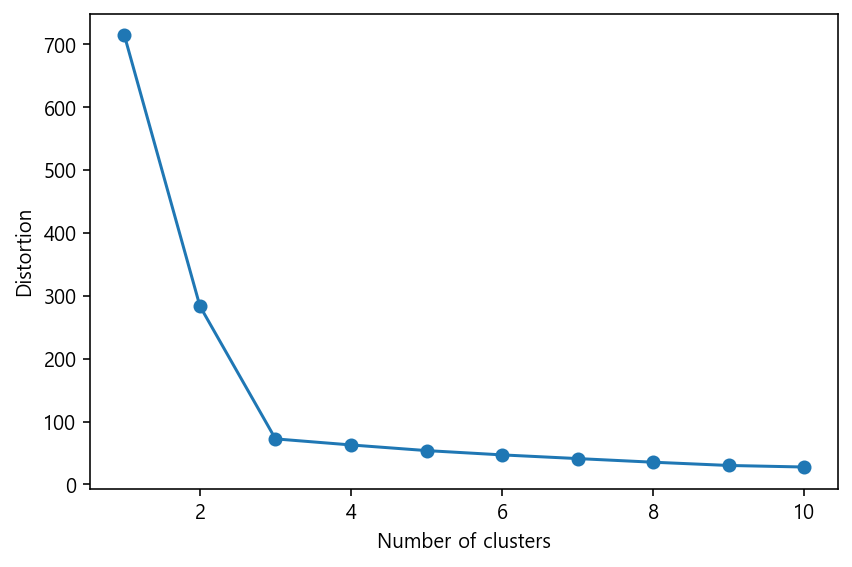

In [18]:
distortions= []
for i in range(1,11):
    km = KMeans(n_clusters=i,
               init='k-means++',
               n_init=10,
               max_iter=300,
               random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

## 11.1.5 실루엣 그래프로 군집 품질을 정량화
클러스터 내 샘플들이 얼마나 조밀하게 모여있는지 측정하는 그래프 도구

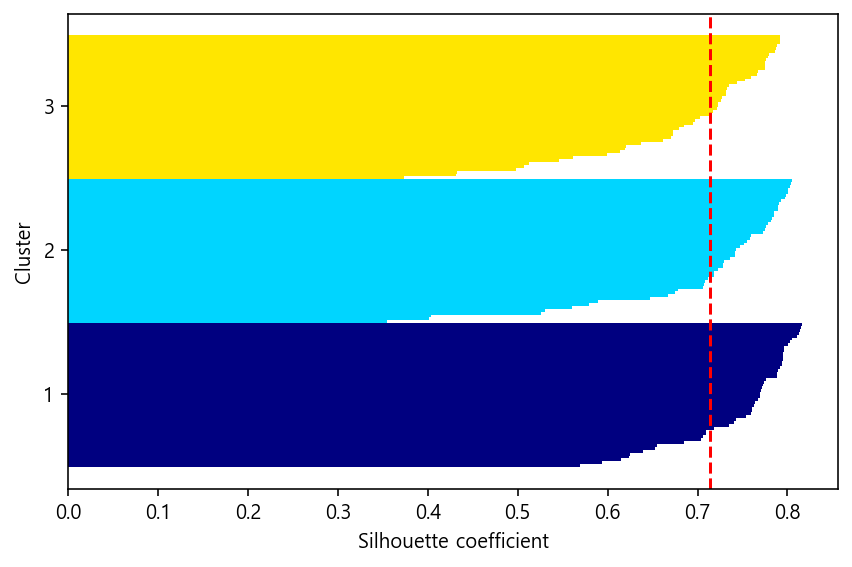

In [20]:
km = KMeans(n_clusters=3, init='k-means++', n_init=10,
           max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(X)

import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')

y_ax_lower, y_ax_upper = 0,0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height=1.0,
            edgecolor='none',
            color=color)
    yticks.append((y_ax_lower + y_ax_upper)/2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color='red', linestyle='--')
plt.yticks(yticks, cluster_labels +1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.tight_layout()
plt.show()

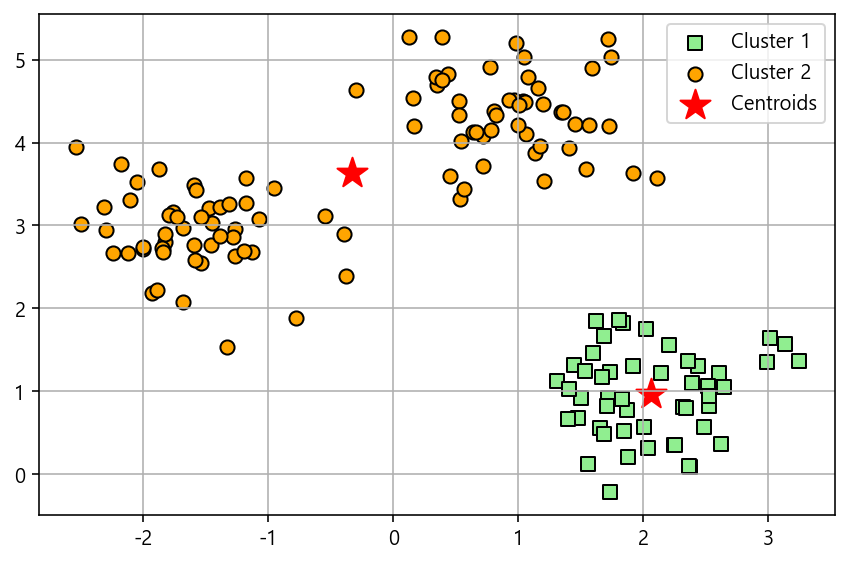

In [21]:
"""잘못된 클러스터링"""

km = KMeans(n_clusters=2,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50,
            c='lightgreen',
            edgecolor='black',
            marker='s',
            label='Cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50,
            c='orange',
            edgecolor='black',
            marker='o',
            label='Cluster 2')

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
            s=250, marker='*', c='red', label='Centroids')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

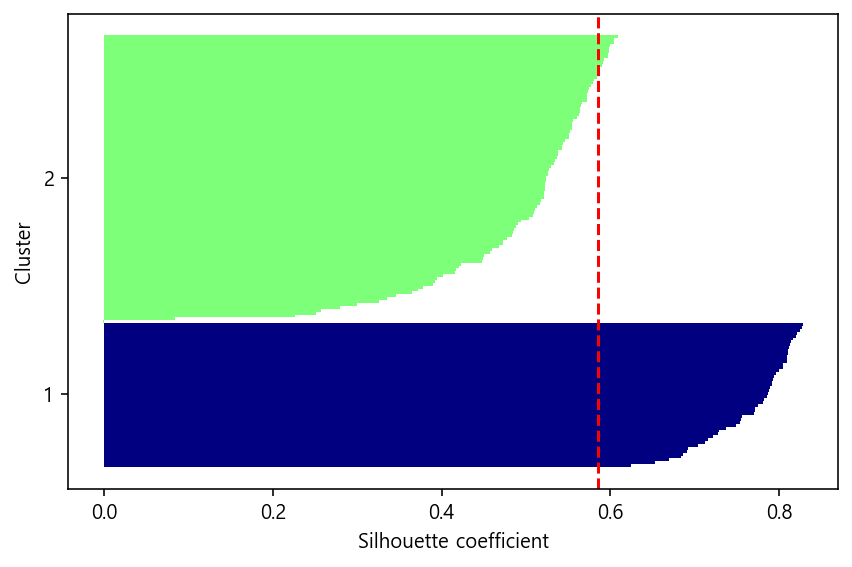

In [22]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
plt.show()

# 11.2 계층적인 트리로 클러스터 조직화
프로토타입 기반 군집의 또 다른 방법  
계층군집: 덴드로그램 O, 클러스터 개수를 미리 지정할 필요 X  
* 병합 계층 군집: 각 샘플이 독립적인 클러스터가 되고, 하나의 클러스터가 남을 때까지 가장 가까운 클러스터를 합치기
* 분할 계층 군집: 전체 샘플을 포함하는 하나의 클러스터에서 시작하여 더 작은 클러스터로, 클러스터 내에 샘플이 하나 남을 때까지 반복적으로 나눔

## 11.2.1 상향식으로 클러스터 묶기
병합 계층 군집의 두가지 기본 알고리즘  
- 단일연결: 클러스터 쌍에서 가장 비슷한 샘플 간 거리 계산 후 거리가 가장 가까운 두 클러스터를 합침
- 완전연결: 클러스터 쌍에서 가장 비슷하지 않은 샘플을 비교하여 병합을 수행

완전 연결 방식을 사용한 병합 군집
1. 모든 샘플의 거리 행렬을 계산
2. 모든 데이터 포인트를 단일 클러스터로 표현
3. 가장 멀리 떨어진 샘플 사이의 거리에 기초해 가장 가까운 두 클러스터를 합침
4. 유사도 행렬 업데이트
5. 하나의 클러스터가 남을 떄까지 단계 2~4 반복

In [23]:
import pandas as pd
import numpy as np
np.random.seed(123)
variables = ['X', 'Y', 'Z']
labels = ['ID_0','ID_1','ID_2','ID_3','ID_4']
X = np.random.random_sample([5,3])*10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


## 11.2.2 거리 행렬에서 계층 군집 수행

In [25]:
from scipy.spatial.distance import pdist, squareform
row_dist = pd.DataFrame(squareform(pdist(df,metric = 'euclidean')), columns=labels, index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


In [28]:
from scipy.cluster.hierarchy import linkage
# # 방식1
# row_clusters = linkage(pdist(df, metric='euclidean'), method='complete')
# # 방식2
row_clusters = linkage(df.values, method='complete',metric='euclidean')

pd.DataFrame(row_clusters,
            columns=['row labels 1', 'row labels 2', 'distance', 'no. of items in clust.'],
            index = ['cluster %d' %(i+1) for i in range(row_clusters.shape[0])])

,row labels 1,row labels 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


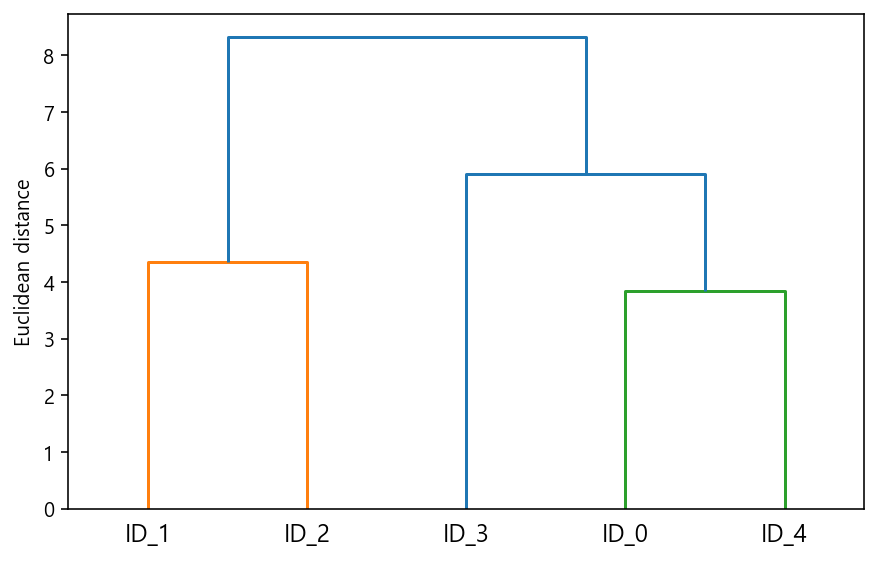

In [29]:
from scipy.cluster.hierarchy import dendrogram
# 검은색 덴드로그램 만들기 (1/2 부분만)
# from scipy.cluster.hierarchy import set_link_color_palette
# set_link_color_palette(['black'])
row_dendr = dendrogram(row_clusters, labels=labels,
                       #color_threshold=np.inf
                      )
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

## 11.2.3 히트맵에 덴드로그램 연결
히트맵과 함께 사용하면 훈련 샘플을 담고있는 데이터 배열이나 행렬의 개별값을 색으로 표현할 수 있음

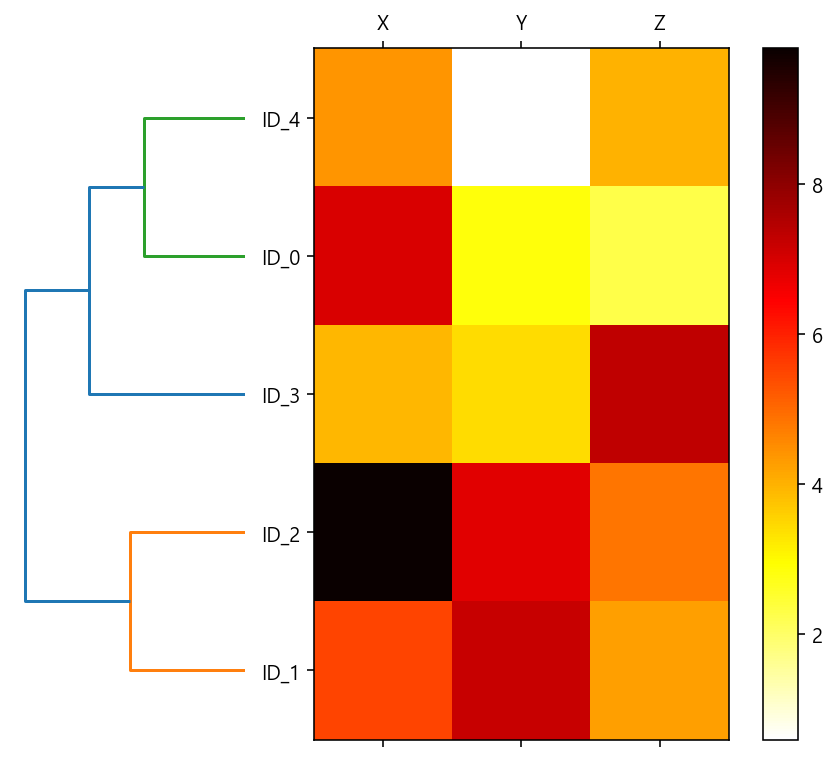

In [31]:
'''1. 새로운 figure 객체를 만들고 ass_axes 메서드를 사용해서
덴드로그램의 x축 위치, y축 위치, 너비, 높이를 지정한다.
그다음 덴드로그램을 반시계 방향으로 90도 회전시킨다.'''
fig = plt.figure(figsize=(8,8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])
row_dendr = dendrogram(row_clusters, orientation='left')

'''2. 파이썬 딕셔너리인 덴드로그램 객체의 leaves 키에서 얻은
클러스터 레이블을 따라 원본 DataFrame에 있는 데이터를 재정렬'''
df_rowclust = df.iloc[row_dendr['leaves'][::-1]]

'''3. 재정렬된 DataFrame에서 히트맵을 만들고 덴드로그램 다음에 위치시킴'''
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')

'''4. 히트맵 설정'''
axd.set_xticks([])
axd.set_yticks([])
for i in axd.spines.values():
    i.set_visible(False)
fig.colorbar(cax)
axm.set_xticklabels(['']+list(df_rowclust.columns))
axm.set_yticklabels(['']+list(df_rowclust.index))
plt.show()

## 11.2.4 사이킷런에서 병합 군집 적용

In [32]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
labels = ac.fit_predict(X)
print('클러스터 레이블: %s' % labels)

클러스터 레이블: [1 0 0 2 1]


In [33]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
labels = ac.fit_predict(X)
print('클러스터 레이블: %s' % labels)

클러스터 레이블: [0 1 1 0 0]


# 11.3 DBSCAN을 사용하여 밀집도가 높은 지역 찾기
DBSCAN(Density-based Spatial clustering od applications with noise)군집 알고리즘
- 원형 클러스터링 가정 X
- 임계치를 수동으로 지정하는 계층적인 방식 X

다음 조건에 따라 레이블 할당
* 핵심 샘플: 어떤 샘플의 특정 반경(ε) 안에 있는 이웃 샘플이 지정된 개수 이상인 경우
* 경계 샘플: 어떤 샘플의 특정 반경(ε) 안에 있는 이웃 샘플이 지정된 개수 이하이지만 다른 핵심 샘플의 반경 안에 있는 경우
* 잡음 샘플: 핵심 샘플도, 경계 샘플도 아닌 경우

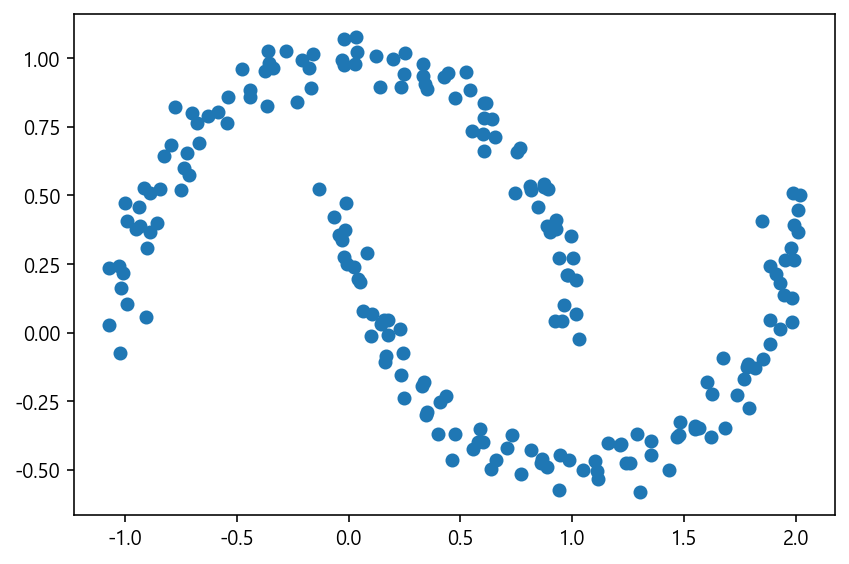

In [34]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
plt.scatter(X[:,0], X[:,1])
plt.tight_layout()
plt.show()

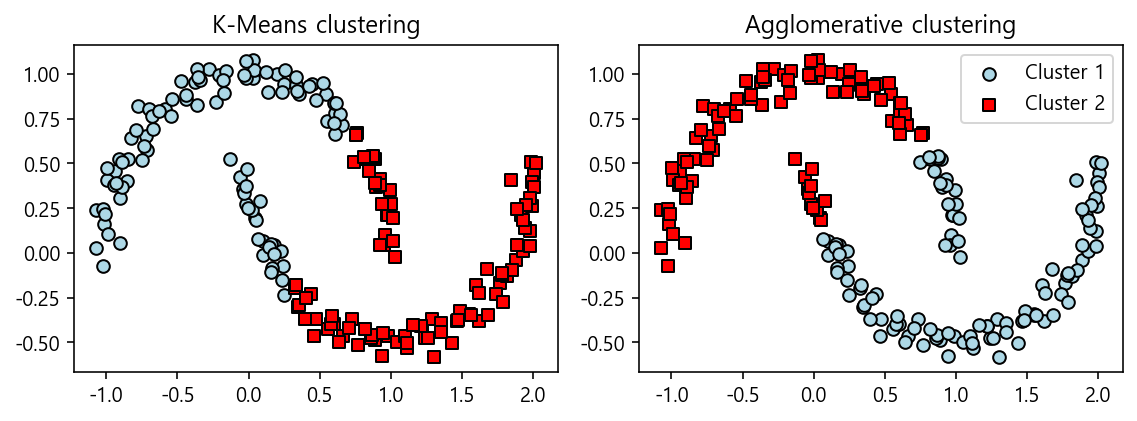

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
km = KMeans(n_clusters=2, random_state=0)
y_km = km.fit_predict(X)
ax1.scatter(X[y_km==0,0], X[y_km==0,1],c='lightblue',
           edgecolor='black', marker='o', s=40, label='cluster 1')
ax1.scatter(X[y_km==1,0], X[y_km==1,1],c='red',
           edgecolor='black', marker='s', s=40, label='cluster 2')
ax1.set_title('K-Means clustering')
ac = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
y_ac = ac.fit_predict(X)

ax2.scatter(X[y_ac == 0, 0], X[y_ac == 0, 1], c='lightblue',
            edgecolor='black', marker='o', s=40, label='Cluster 1')
ax2.scatter(X[y_ac == 1, 0], X[y_ac == 1, 1], c='red',
            edgecolor='black', marker='s', s=40, label='Cluster 2')
ax2.set_title('Agglomerative clustering')


plt.legend()
plt.tight_layout()
plt.show()

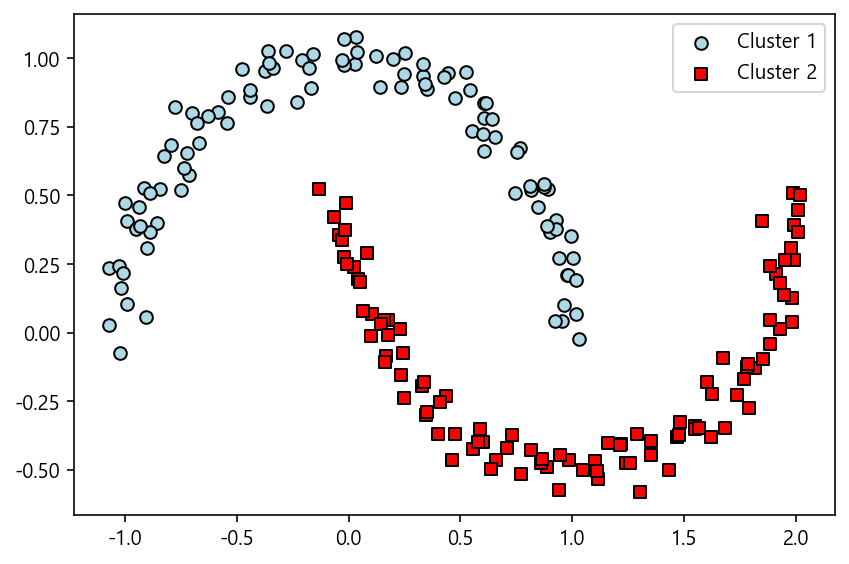

In [39]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
y_db = db.fit_predict(X)
plt.scatter(X[y_db == 0, 0], X[y_db == 0, 1],
            c='lightblue', marker='o', s=40,
            edgecolor='black', label='Cluster 1')
plt.scatter(X[y_db == 1, 0], X[y_db == 1, 1],
            c='red', marker='s', s=40,
            edgecolor='black', label='Cluster 2')
plt.legend()
plt.tight_layout()
plt.show()